In [1]:
from config import CONFIG
from utils import series_to_supervised

CONFIG

{'columns': ['Close', 'Volume', 'Low', 'High'],
 'csv_src_file': 'BTC_ETH',
 'filename': 'BTC_ETH_conv_lstm3x32_i48_o12_Close_Volume_Low_High',
 'folder': {'data': 'data/', 'weights': 'weights/'},
 'input_size': 48,
 'lstm_hidden_size': 20,
 'name': 'conv_lstm3x32',
 'output_size': 12,
 'pair': 'BTC_ETH',
 'period': 300}

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot
 
#data file path
dfp = ''.join([CONFIG['folder']['data'], CONFIG['csv_src_file'], '.csv'])

#Columns of price data to use
columns = CONFIG['columns']
# df = pd.read_csv(dfp).dropna().tail(1000000)
dataset = pd.read_csv(dfp)

# to drop values before 2018 1514764800, March 2018 1519862400, July 2017 1498867200
dataset = dataset[-10000:] #[dataset.Timestamp > 1519862400]
dataset.head()

,Close,Timestamp,High,Low,Open,Volume
289089,0.080508,1525737300,0.080533,0.080205,0.080205,5.226731
289090,0.080600,1525737600,0.080600,0.080508,0.080508,5.065647
289091,0.080704,1525737900,0.080704,0.080600,0.080600,5.141022
289092,0.080598,1525738200,0.080704,0.080598,0.080704,2.380190
289093,0.080792,1525738500,0.080800,0.080598,0.080600,1.551881


In [3]:
values = dataset.loc[:,columns].values
values.shape
values

array([[  8.05082800e-02,   5.22673117e+00,   8.02050000e-02,
          8.05328100e-02],
       [  8.06002000e-02,   5.06564654e+00,   8.05082800e-02,
          8.06002000e-02],
       [  8.07039700e-02,   5.14102168e+00,   8.06002000e-02,
          8.07040000e-02],
       ..., 
       [  7.74100000e-02,   1.37301326e+00,   7.74100000e-02,
          7.74908000e-02],
       [  7.74360000e-02,   1.59254290e-01,   7.74093800e-02,
          7.74591300e-02],
       [  7.74173300e-02,   1.27900000e-05,   7.74173300e-02,
          7.74173300e-02]])

The new Strategy is to:
 * Perform a diff of x(t+1) - x(t) as the data is a random walk
 * Scale each input independently
 * Apply a first Conv1D layer to extract features

In [4]:
# Work on a diff
#diff = list()
#for i in range(1, len(values)):
    # Adjust Close Volume Low High do not touch Volumes
    #value = [values[i][0] - values[i - 1][0],
    #         values[i][1],
    #         values[i][2] - values[i - 1][2],
    #         values[i][3] - values[i - 1][3]]
    #diff.append(value)
diff = values


In [5]:
# parameters to prepare the dataset for learning 
n_lag = CONFIG['input_size']
n_out = CONFIG['output_size']
n_features = len(columns)
n_lag,n_features,n_out

(48, 4, 12)

In [6]:
# scale dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(diff)

In [7]:
# frame as supervised learning
reframed = series_to_supervised(scaled, n_lag, n_out)
print(reframed.shape)
reframed.head(10)

(9941, 240)


,var1(t-48),var2(t-48),var3(t-48),var4(t-48),var1(t-47),var2(t-47),var3(t-47),var4(t-47),var1(t-46),var2(t-46),...,var3(t+9),var4(t+9),var1(t+10),var2(t+10),var3(t+10),var4(t+10),var1(t+11),var2(t+11),var3(t+11),var4(t+11)
48,0.629558,0.014927,0.619340,0.592130,0.636038,0.014467,0.640199,0.596736,0.643354,0.014682,...,0.698090,0.653454,0.678323,0.014079,0.680558,0.647987,0.673158,0.013533,0.682465,0.651251
49,0.636038,0.014467,0.640199,0.596736,0.643354,0.014682,0.646521,0.603831,0.635883,0.006798,...,0.680558,0.647987,0.673158,0.013533,0.682465,0.651251,0.689603,0.003465,0.682792,0.650721
50,0.643354,0.014682,0.646521,0.603831,0.635883,0.006798,0.646370,0.603831,0.649530,0.004432,...,0.682465,0.651251,0.689603,0.003465,0.682792,0.650721,0.684316,0.004140,0.682822,0.651063
51,0.635883,0.006798,0.646370,0.603831,0.649530,0.004432,0.646370,0.610393,0.641312,0.006290,...,0.682792,0.650721,0.684316,0.004140,0.682822,0.651063,0.661032,0.010717,0.652562,0.644551
52,0.649530,0.004432,0.646370,0.610393,0.641312,0.006290,0.649619,0.624311,0.654354,0.004982,...,0.682822,0.651063,0.661032,0.010717,0.652562,0.644551,0.650105,0.000570,0.660244,0.628849
53,0.641312,0.006290,0.649619,0.624311,0.654354,0.004982,0.653419,0.626492,0.661051,0.003300,...,0.652562,0.644551,0.650105,0.000570,0.660244,0.628849,0.659863,0.013866,0.652585,0.637734
54,0.654354,0.004982,0.653419,0.626492,0.661051,0.003300,0.665078,0.629561,0.663871,0.000461,...,0.660244,0.628849,0.659863,0.013866,0.652585,0.637734,0.645341,0.009773,0.655597,0.637756
55,0.661051,0.003300,0.665078,0.629561,0.663871,0.000461,0.670597,0.634281,0.669159,0.015449,...,0.652585,0.637734,0.645341,0.009773,0.655597,0.637756,0.669178,0.001399,0.671267,0.646963
56,0.663871,0.000461,0.670597,0.634281,0.669159,0.015449,0.654217,0.633272,0.665376,0.002024,...,0.655597,0.637756,0.669178,0.001399,0.671267,0.646963,0.656450,0.001223,0.662833,0.646564
57,0.669159,0.015449,0.654217,0.633272,0.665376,0.002024,0.657855,0.628711,0.661404,0.001776,...,0.671267,0.646963,0.656450,0.001223,0.662833,0.646564,0.643640,0.009030,0.653042,0.615843


In [8]:
# drop columns we don't want to predict
# We're only concerned with the estimating the close value,
# Close should be first in the list of column in the config file

cols_to_drop = []

for i in range (n_out):
    for j in range(1, n_features):
        cols_to_drop.append(reframed.shape[1]-(i*n_features+j))
print cols_to_drop
reframed.drop(reframed.columns[cols_to_drop], axis=1, inplace=True)

reframed.head()

[239, 238, 237, 235, 234, 233, 231, 230, 229, 227, 226, 225, 223, 222, 221, 219, 218, 217, 215, 214, 213, 211, 210, 209, 207, 206, 205, 203, 202, 201, 199, 198, 197, 195, 194, 193]


,var1(t-48),var2(t-48),var3(t-48),var4(t-48),var1(t-47),var2(t-47),var3(t-47),var4(t-47),var1(t-46),var2(t-46),...,var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6),var1(t+7),var1(t+8),var1(t+9),var1(t+10),var1(t+11)
48,0.629558,0.014927,0.619340,0.592130,0.636038,0.014467,0.640199,0.596736,0.643354,0.014682,...,0.694423,0.700246,0.700145,0.710048,0.694549,0.697710,0.688898,0.688898,0.678323,0.673158
49,0.636038,0.014467,0.640199,0.596736,0.643354,0.014682,0.646521,0.603831,0.635883,0.006798,...,0.700246,0.700145,0.710048,0.694549,0.697710,0.688898,0.688898,0.678323,0.673158,0.689603
50,0.643354,0.014682,0.646521,0.603831,0.635883,0.006798,0.646370,0.603831,0.649530,0.004432,...,0.700145,0.710048,0.694549,0.697710,0.688898,0.688898,0.678323,0.673158,0.689603,0.684316
51,0.635883,0.006798,0.646370,0.603831,0.649530,0.004432,0.646370,0.610393,0.641312,0.006290,...,0.710048,0.694549,0.697710,0.688898,0.688898,0.678323,0.673158,0.689603,0.684316,0.661032
52,0.649530,0.004432,0.646370,0.610393,0.641312,0.006290,0.649619,0.624311,0.654354,0.004982,...,0.694549,0.697710,0.688898,0.688898,0.678323,0.673158,0.689603,0.684316,0.661032,0.650105


In [9]:
reframed_values = reframed.values
# split into train and test sets
training_size = int(0.8* reframed_values.shape[0])
train = reframed_values[:training_size, :]
test = reframed_values[training_size:, :]

In [11]:
# split into input and outputs
n_obs = n_lag * n_features

# We're only concerned with the estimating the close value,
# Close should be first in the list of column in the config file

n_outputs = n_out * n_features
train_x, train_y = train[:, :n_obs], train[:, -n_out:]
test_x, test_y = test[:, :n_obs], test[:, -n_out:]
# reshape input to be 3D [samples, timesteps, features]
train_x = train_x.reshape((train_x.shape[0], n_lag, n_features))
test_x = test_x.reshape((test_x.shape[0], n_lag, n_features))

print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

((7952, 48, 4), (7952, 12), (1989, 48, 4), (1989, 12))


In [12]:
file_name=''.join([CONFIG['folder']['data'], CONFIG['filename'], '.h5'])

In [13]:
#import h5py
#with h5py.File(file_name, 'w') as f:
#    f.create_dataset("train_x", data = train_x)
#    f.create_dataset('train_y', data = train_y)
#    f.create_dataset("test_x", data = test_x)
#    f.create_dataset("test_y", data = test_y)
#    f.create_dataset("dataset", data = dataset)

In [14]:
model_name=''.join([CONFIG['folder']['weights'], CONFIG['filename'], '_model', '.json'])
model_weights_name=''.join([CONFIG['folder']['weights'], CONFIG['filename'], '_model_weights', '.h5'])

In [57]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input
from keras.layers import LSTM, CuDNNLSTM, GRU,CuDNNGRU
from keras.layers import Conv1D, AveragePooling1D, MaxPooling1D
from keras.layers import Dropout, Flatten
from keras.layers import Activation, BatchNormalization
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import RepeatVector
from keras.callbacks import ModelCheckpoint

units= CONFIG['lstm_hidden_size']
dropout = .1

# design network
model = Sequential()
model.add(Bidirectional(LSTM(units), input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(dropout))

model.add(RepeatVector(n_out))

model.add(LSTM(units, return_sequences=True))
model.add(Dropout(dropout))

# We're only concerned with the estimating the close value,
# otherwise use n_outputs instead of 1
# Dense(n_outputs, ...
model.add(TimeDistributed(Dense(1, activation='relu')))

model.compile(loss='mse', optimizer='adam')

# store model
# serialize model to JSON
model_json = model.to_json()
with open(model_name, "w") as json_file:
    json_file.write(model_json)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 40)                4000      
_________________________________________________________________
dropout_1 (Dropout)          (None, 40)                0         
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 12, 40)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 12, 20)            4880      
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 20)            0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 12, 1)             21        
Total params: 8,901
Trainable params: 8,901
Non-trainable params: 0
_________________________________________________________________
None


In [58]:
train_y = train_y.reshape(-1, n_out, 1)
test_y = test_y.reshape(-1, n_out, 1)

In [59]:
epochs=100
batch_size=32

In [60]:
# fit network
history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size,
                    validation_data=(test_x, test_y), verbose=1, shuffle=False,
                    callbacks=[ModelCheckpoint(model_weights_name, monitor='val_loss', verbose=1,save_best_only='true',
                                              save_weights_only=True)])

Train on 7952 samples, validate on 1989 samples
Epoch 1/100
7936/7952 [============================>.] - ETA: 0s - loss: 0.0294Epoch 00001: val_loss improved from inf to 0.00557, saving model to weights/BTC_ETH_conv_lstm3x32_i48_o12_Close_Volume_Low_High_model_weights.h5
weights/BTC_ETH_conv_lstm3x32_i48_o12_Close_Volume_Low_High_model_weights.h5
7952/7952 [==============================] - 19s 2ms/step - loss: 0.0293 - val_loss: 0.0056
Epoch 2/100
7936/7952 [============================>.] - ETA: 0s - loss: 0.0101Epoch 00002: val_loss improved from 0.00557 to 0.00428, saving model to weights/BTC_ETH_conv_lstm3x32_i48_o12_Close_Volume_Low_High_model_weights.h5
weights/BTC_ETH_conv_lstm3x32_i48_o12_Close_Volume_Low_High_model_weights.h5
7952/7952 [==============================] - 16s 2ms/step - loss: 0.0101 - val_loss: 0.0043
Epoch 3/100
7936/7952 [============================>.] - ETA: 0s - loss: 0.0091Epoch 00003: val_loss improved from 0.00428 to 0.00356, saving model to weights/BTC

Epoch 22/100
7936/7952 [============================>.] - ETA: 0s - loss: 0.0035Epoch 00022: val_loss improved from 0.00100 to 0.00095, saving model to weights/BTC_ETH_conv_lstm3x32_i48_o12_Close_Volume_Low_High_model_weights.h5
weights/BTC_ETH_conv_lstm3x32_i48_o12_Close_Volume_Low_High_model_weights.h5
7952/7952 [==============================] - 16s 2ms/step - loss: 0.0034 - val_loss: 9.4712e-04
Epoch 23/100
7936/7952 [============================>.] - ETA: 0s - loss: 0.0033Epoch 00023: val_loss improved from 0.00095 to 0.00094, saving model to weights/BTC_ETH_conv_lstm3x32_i48_o12_Close_Volume_Low_High_model_weights.h5
weights/BTC_ETH_conv_lstm3x32_i48_o12_Close_Volume_Low_High_model_weights.h5
7952/7952 [==============================] - 14s 2ms/step - loss: 0.0033 - val_loss: 9.4498e-04
Epoch 24/100
7904/7952 [============================>.] - ETA: 0s - loss: 0.0033Epoch 00024: val_loss improved from 0.00094 to 0.00093, saving model to weights/BTC_ETH_conv_lstm3x32_i48_o12_Close_

Epoch 47/100
7952/7952 [==============================] - 16s 2ms/step - loss: 0.0019 - val_loss: 6.7352e-04
Epoch 48/100
7952/7952 [==============================] - 17s 2ms/step - loss: 0.0018 - val_loss: 6.7763e-04
Epoch 49/100
7936/7952 [============================>.] - ETA: 0s - loss: 0.0019Epoch 00049: val_loss improved from 0.00067 to 0.00066, saving model to weights/BTC_ETH_conv_lstm3x32_i48_o12_Close_Volume_Low_High_model_weights.h5
weights/BTC_ETH_conv_lstm3x32_i48_o12_Close_Volume_Low_High_model_weights.h5
7952/7952 [==============================] - 18s 2ms/step - loss: 0.0019 - val_loss: 6.6430e-04
Epoch 50/100
7936/7952 [============================>.] - ETA: 0s - loss: 0.0018Epoch 00050: val_loss improved from 0.00066 to 0.00063, saving model to weights/BTC_ETH_conv_lstm3x32_i48_o12_Close_Volume_Low_High_model_weights.h5
weights/BTC_ETH_conv_lstm3x32_i48_o12_Close_Volume_Low_High_model_weights.h5
7952/7952 [==============================] - 18s 2ms/step - loss: 0.0018 -

7952/7952 [==============================] - 15s 2ms/step - loss: 0.0016 - val_loss: 5.4648e-04
Epoch 78/100
7952/7952 [==============================] - 14s 2ms/step - loss: 0.0016 - val_loss: 5.4612e-04
Epoch 79/100
7904/7952 [============================>.] - ETA: 0s - loss: 0.0016Epoch 00079: val_loss improved from 0.00054 to 0.00053, saving model to weights/BTC_ETH_conv_lstm3x32_i48_o12_Close_Volume_Low_High_model_weights.h5
weights/BTC_ETH_conv_lstm3x32_i48_o12_Close_Volume_Low_High_model_weights.h5
7952/7952 [==============================] - 14s 2ms/step - loss: 0.0016 - val_loss: 5.2778e-04
Epoch 80/100
7904/7952 [============================>.] - ETA: 0s - loss: 0.0016Epoch 00080: val_loss improved from 0.00053 to 0.00053, saving model to weights/BTC_ETH_conv_lstm3x32_i48_o12_Close_Volume_Low_High_model_weights.h5
weights/BTC_ETH_conv_lstm3x32_i48_o12_Close_Volume_Low_High_model_weights.h5
7952/7952 [==============================] - 13s 2ms/step - loss: 0.0016 - val_loss: 5.

In [40]:
# Load the best weights
model.load_weights(model_weights_name)
model.compile(loss='mse', optimizer='adam')
model.evaluate(test_x, test_y)

weights/BTC_ETH_conv_lstm3x32_i48_o12_Close_Volume_Low_High_model_weights.h5
1989/1989 [==============================] - 2s 822us/step


0.00040790437340976129

In [41]:
from matplotlib import pyplot

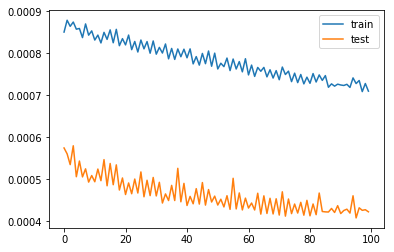

In [42]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()



In [52]:
y = model.predict(test_x)

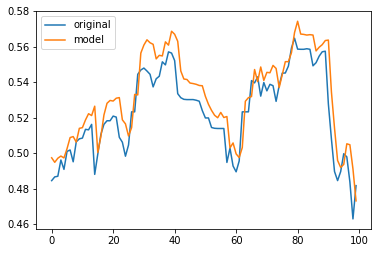

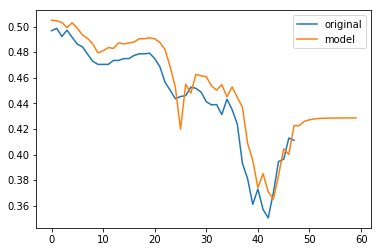

In [53]:
a = test_y[:,0]
b = y[:,0]

c = np.append(b, y[-1], axis=0)

pyplot.plot(a[:100], label='original')
#pyplot.plot(values[training_size:], label='orig')
pyplot.plot(b[:100], label='model')
pyplot.legend()
pyplot.show()

pos = int(a.shape[0]-n_out*4)

pyplot.plot(a[pos:], label='original')
#pyplot.plot(values[training_size:], label='orig')
pyplot.plot(c[pos:], label='model')
pyplot.legend()
pyplot.show()


In [54]:
#Realtime processing!
period = CONFIG['period']
import time
import urllib2
import json

# Download a live bitcoin price data set
def dl_X(now = None, points = n_lag, period = period, pair=CONFIG['pair']):
    if now == None:
        now = time.time() 
    end = now - now % period
    #print end, time.strftime("%a, %d %b %Y %H:%M:%S +0000", time.gmtime(end))
    start = end - points*period
    #print start, time.strftime("%a, %d %b %Y %H:%M:%S +0000", time.gmtime(start))
    url = "https://poloniex.com/public?command=returnChartData&currencyPair=%s&start=%d&end=%d&period=%d" % (pair, start, end, period)
    openUrl = urllib2.urlopen(url)
    r = openUrl.read()
    openUrl.close()
    d = json.loads(r.decode())[-n_lag:]
    df = pd.DataFrame(d)
    original_columns=[u'close', u'date', u'high', u'low', u'open',u'volume']
    new_columns = ['Close','Timestamp','High','Low','Open','Volume']
    df = df.loc[:,original_columns]
    df.columns = new_columns
    
    return df
    
rt_df = dl_X()
rt_df.head()

,Close,Timestamp,High,Low,Open,Volume
0,0.078820,1529493000,0.078930,0.078770,0.078855,2.642825
1,0.078870,1529493300,0.078960,0.078810,0.078825,0.384616
2,0.078870,1529493600,0.078960,0.078867,0.078870,0.342024
3,0.078810,1529493900,0.078870,0.078810,0.078870,0.793172
4,0.078875,1529494200,0.078875,0.078825,0.078825,0.378359


In [55]:
def predict(when=None):
    rt_df = dl_X(when)
    rt_values = rt_df.loc[:,columns].values
    rt_scaled = scaler.transform(rt_values)
    rt_x = rt_scaled.reshape((1, n_lag, n_features))
    print rt_x.shape
    return rt_scaled, model.predict(rt_x)

(1, 48, 4)


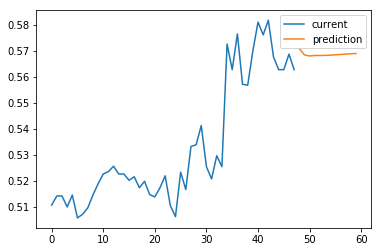

(1, 48, 4)


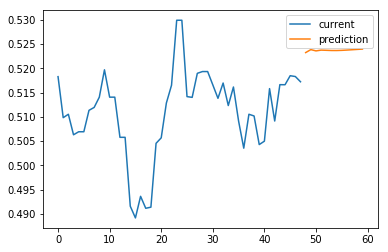

(1, 48, 4)


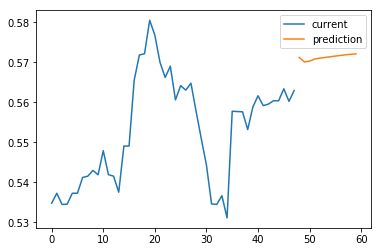

(1, 48, 4)


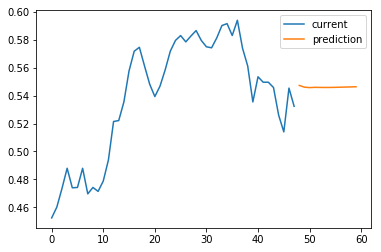

(1, 48, 4)


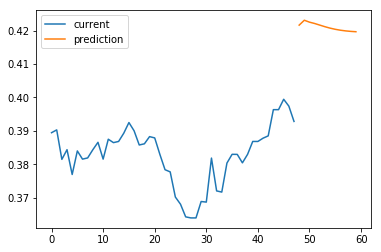

(1, 48, 4)


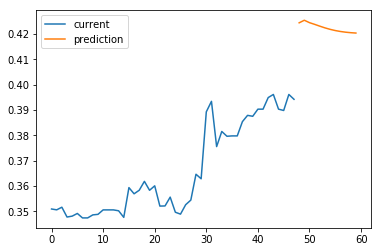

(1, 48, 4)


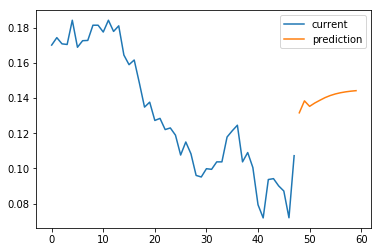

In [56]:
# do some now & past predictions
for t in [0, 100, 200, 300, 500, 1000, 2000]:
    rt_x, prediction = predict(time.time()-t*period)

    current = rt_x[:,0]
    prediction = prediction[0]

    pyplot.plot(current, label='current')

    # shift train predictions for plotting
    predictPlot = np.empty_like(current)
    predictPlot[:] = np.nan
    predictPlot = np.append(predictPlot, prediction)

    pyplot.plot(predictPlot, label='prediction')
    pyplot.legend()
    pyplot.show()

Wed, 20 Jun 2018 15:05:00 +0000
(1, 48, 4)


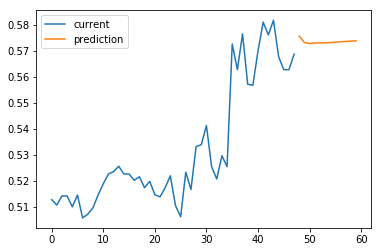

KeyboardInterrupt: 

In [49]:
starttime=time.time()
while True:
    now = time.time() 
    end = now - now % period
    print time.strftime("%a, %d %b %Y %H:%M:%S +0000", time.gmtime(end))
    rt_x, prediction = predict()

    current = rt_x[:,0]
    prediction = prediction[0]

    pyplot.plot(current, label='current')

    # shift train predictions for plotting
    predictPlot = np.empty_like(current)
    predictPlot[:] = np.nan
    predictPlot = np.append(predictPlot, prediction)

    pyplot.plot(predictPlot, label='prediction')
    pyplot.legend()
    pyplot.show()

    time.sleep(period - ((time.time() - starttime) % period))

In [ ]:
print units, n_lag


In [ ]:
print model_weights_name
